In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-v0_8-darkgrid')

In [2]:
# # see available themes
# style.available

## Definition of the system
Given system is y(n) = 2x(2n-2). Given an input signal x(n) to this system -

Step-1 (Shifting): the system left-shifts the signal 2 units. Output is x(n-2).

Step-2 (Flipping): there is no flip operation, so this step is skipped. 

Step-3 (Scaling): the system scales the signal from step-1 by 2. Output is x(2n-2)

Step-4 (Constant multiplication): Finally, the system multiplies 2 to the signal from step-3. Output is 2x(2n-2)

Implementation for the above operations are done in the 'System' class. This is a generalized class which can be modified using the parameters shift, flip, scale and amplitude_scale. As a result, this 'System' class can support any type of discrete-time system including y(n) = 2x(2n-2), which is required for this assessment.

The signal structure is definde in the 'Signal' class. It has the signal amplitude array called 'values' and the origin. This class also implements a method to plot the signal.

In [3]:
from __future__ import annotations
class Signal:
    def __init__(self, signal: list | np.ndarray, origin_index: int): # origin_index is 0 based indexing in np.array
        if origin_index < 0 or origin_index >= len(signal):
            raise IndexError("origin_index is out of bounds for signal")
        self.values = np.array(signal)
        self.origin = origin_index
    def pad_signal(self, pad: tuple): # pad 0, when origin becomes negative or greater than the size of the list after shifting
        self.values = np.pad(self.values, pad, mode='constant')
    def copy(self) -> Signal: 
        return Signal(self.values, self.origin)
    def __repr__(self): # to print in notebook cell output
        return f"Signal(values={self.values}, origin={self.origin})"
    
    def plot(self, title, linewidth=2, color='b'):
        xtick = np.arange(0-self.origin, self.values.shape[0]-self.origin, 1)
        max_val = np.max(self.values)
        min_val = np.min(self.values)
        plt.axis([np.min(xtick)-0.2, np.max(xtick)+0.2, min_val-0.5, max_val+0.5])
        plt.xticks(xtick)
        plt.yticks(np.arange(min_val, max_val+1, (max_val-min_val)/10))
        plt.title(title)
        markerline, stemline, baseline = plt.stem(xtick, self.values)
        plt.setp(markerline, color=color)
        plt.setp(stemline, linewidth=linewidth, color=color)
        plt.setp(baseline, color=color)
    
class System:
    def __init__(self, shift: int=0, flip: bool=False, scale: float=1.0, amplitude_scale: float=1.0) -> None:
        self.shift = shift
        self.flip = flip
        self.scale = scale
        self.amplitude_scale = amplitude_scale
    def shift_signal(self, signal: Signal) -> Signal:
        new_signal = signal.copy()
        new_origin = new_signal.origin + self.shift
        if new_origin >= new_signal.values.shape[0]:
            pad = new_origin - new_signal.values.shape[0] + 1
            new_signal.pad_signal((0,pad))
        elif new_origin < 0:
            new_signal.pad_signal((np.abs(new_origin), 0))
            new_origin = 0
        new_signal.origin = new_origin
        return new_signal
    
    def flip_signal(self, signal: Signal) -> Signal:
        new_signal = signal.copy()
        # reverse the signal
        new_signal.values = np.array(new_signal.values[::-1]) 
        # find the new origin
        new_signal.origin = new_signal.values.shape[0] - new_signal.origin - 1
        return new_signal
    
    def scale_signal(self, signal: Signal) -> Signal:
        values, i = [signal.values[signal.origin]], signal.origin + self.scale
        origin = 0 # at beginning, only origin value of the signal is inserted to 'values' list, so, this 'origin' variable is set to 0

        while(i <= signal.values.shape[0]-0.6): # take the values on the right of origin
            # print("+ve", i, np.round(i), abs(i-np.round(i)), np.isclose(abs(i - np.round(i)), 0.0, rtol=1e-09, atol=1e-09))
            if np.isclose(abs(i - np.round(i)), 0.0, rtol=1e-09, atol=1e-09): # meaning, the index is an integer
                values.append(signal.values[np.round(i).astype(int)])
            else:
                values.append(0)
            i+=self.scale

        i = signal.origin - self.scale
        while(i >= -0.4): # take the values on the left of origin
            # print("-ve", i, np.round(i), abs(i-np.round(i)), np.isclose(abs(i - np.round(i)), 0.0, rtol=1e-09, atol=1e-09))
            if np.isclose(abs(i - np.round(i)), 0.0, rtol=1e-09, atol=1e-09):
                values.insert(0,signal.values[np.round(i).astype(int)])
            else:
                values.insert(0,0)
            i-=self.scale
            origin+=1 # since, new values are being inserted before the origin, the origin index should slide right.
        return Signal(signal=values, origin_index=origin)
    
    def constant_multiply(self, signal: Signal) -> Signal:
        return Signal(signal = signal.values * self.amplitude_scale, origin_index = signal.origin)
    
    def transform(self, signal: Signal) -> Signal: # does all operations sequentially. shift -> flip (if needed) -> scale -> constant_multiply
        new_signal = self.shift_signal(signal)
        if self.flip:
            new_signal = self.flip_signal(new_signal)
        new_signal = self.scale_signal(new_signal)
        new_signal = self.constant_multiply(new_signal)
        return new_signal

## Define the System y(n) = 2x(2n-2)

In [4]:
T = System(shift=-2, scale=2, flip=False, amplitude_scale=2)

### Define Signal

In [5]:
x = Signal([2,5,9,3,-1,2,9,-2,0,-5,4,-6,1,7,-3], origin_index=1)

#### Plot Original signal and System's final output

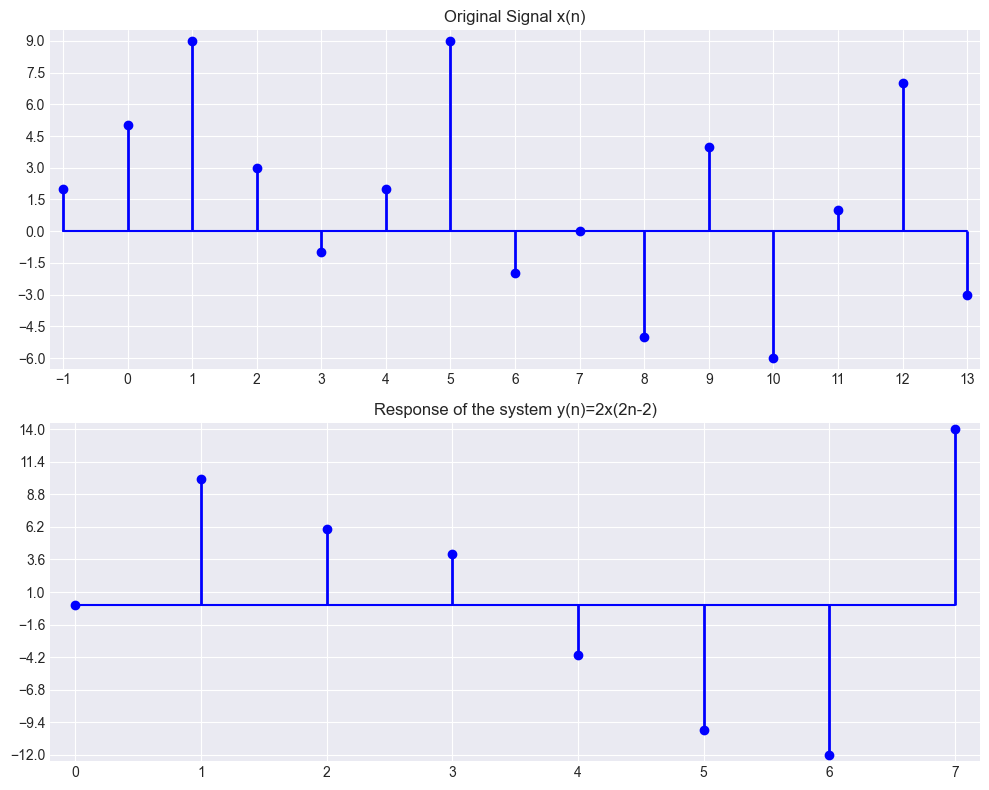

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
x.plot(title='Original Signal x(n)')
plt.subplot(2,1,2)
T.transform(x).plot('Response of the system y(n)=2x(2n-2)')
plt.tight_layout()
plt.show()

#### Individual step plot

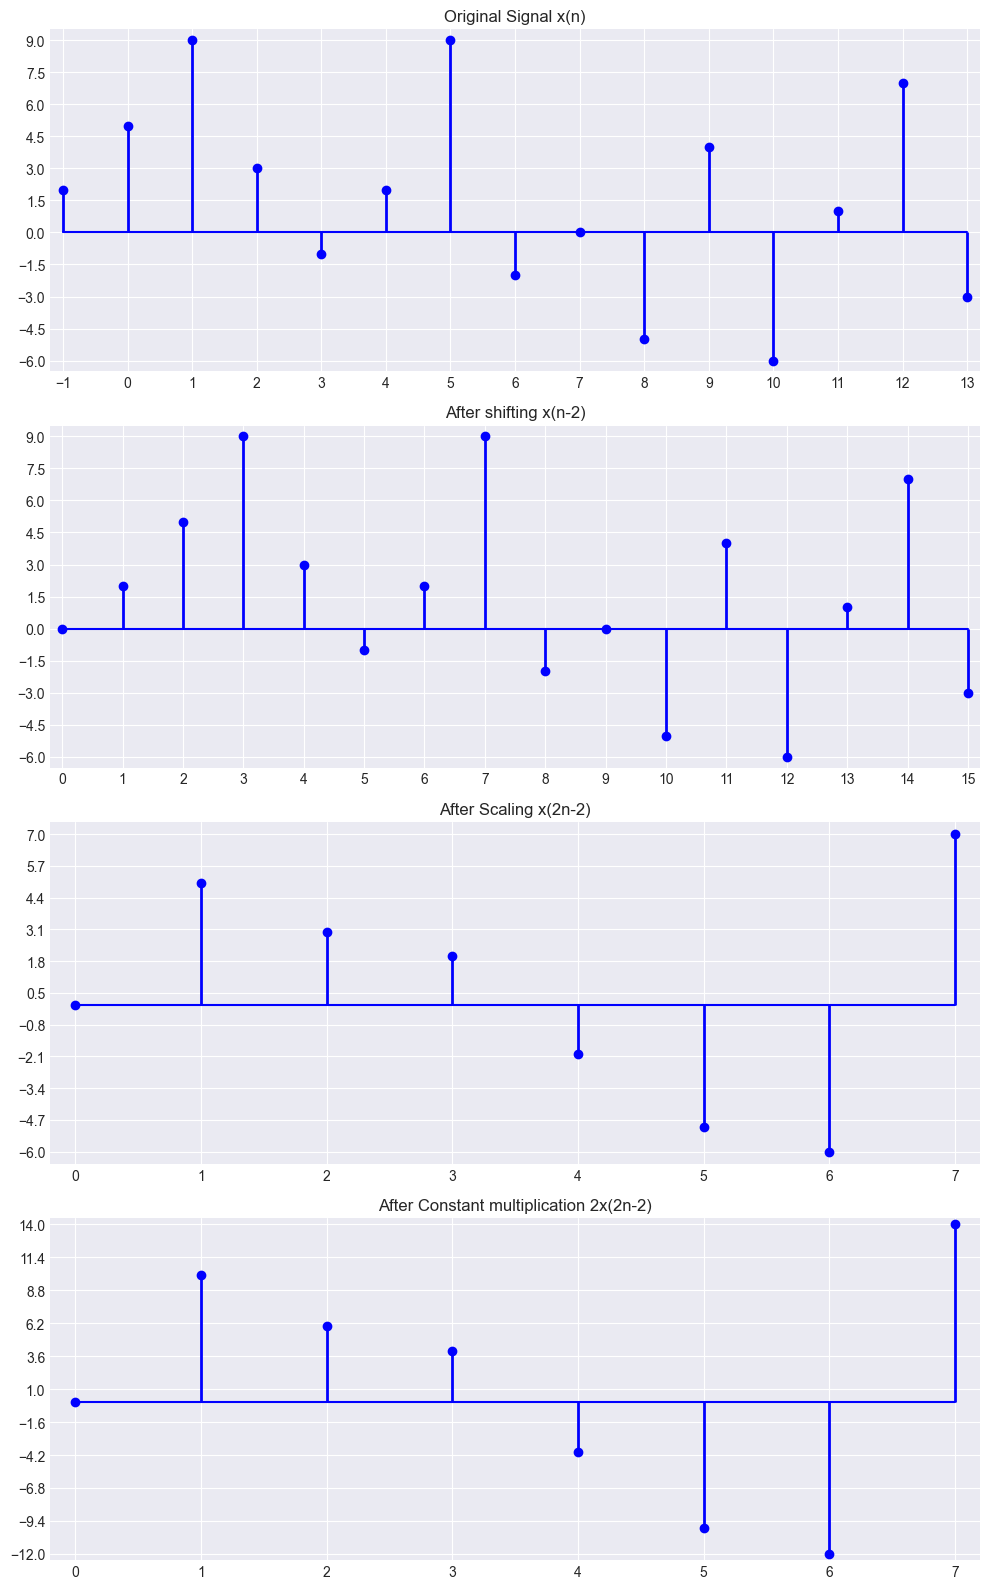

In [7]:
plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
x.plot(title='Original Signal x(n)')
plt.subplot(4,1,2)
xs = T.shift_signal(x)
xs.plot('After shifting x(n-2)')
plt.subplot(4,1,3)
xs = T.scale_signal(xs)
xs.plot('After Scaling x(2n-2)')
plt.subplot(4,1,4)
xs = T.constant_multiply(xs)
xs.plot('After Constant multiplication 2x(2n-2)')
plt.tight_layout()
plt.show()

### Define Another Signal

In [8]:
x = Signal([3,9,4,3,2,1,-3,1,6,-5,4,7,-8], origin_index=5)

#### Plot Original signal and System's final output

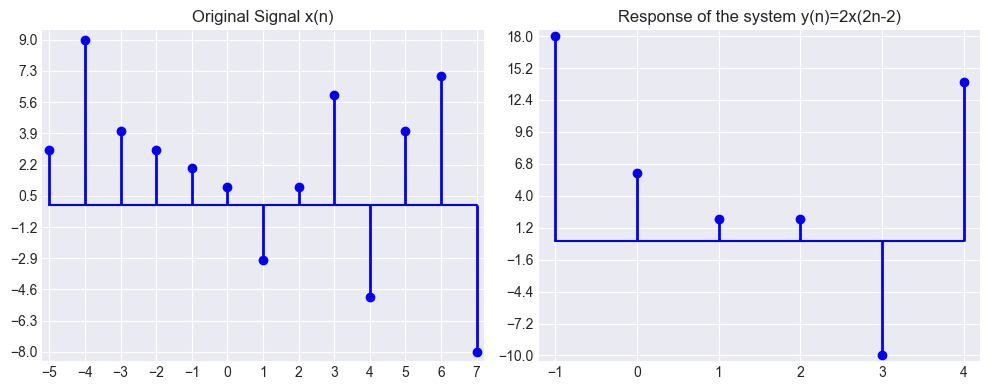

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
x.plot(title='Original Signal x(n)')
plt.subplot(1,2,2)
T.transform(x).plot('Response of the system y(n)=2x(2n-2)')
plt.tight_layout()
plt.show()

#### Individual step plot

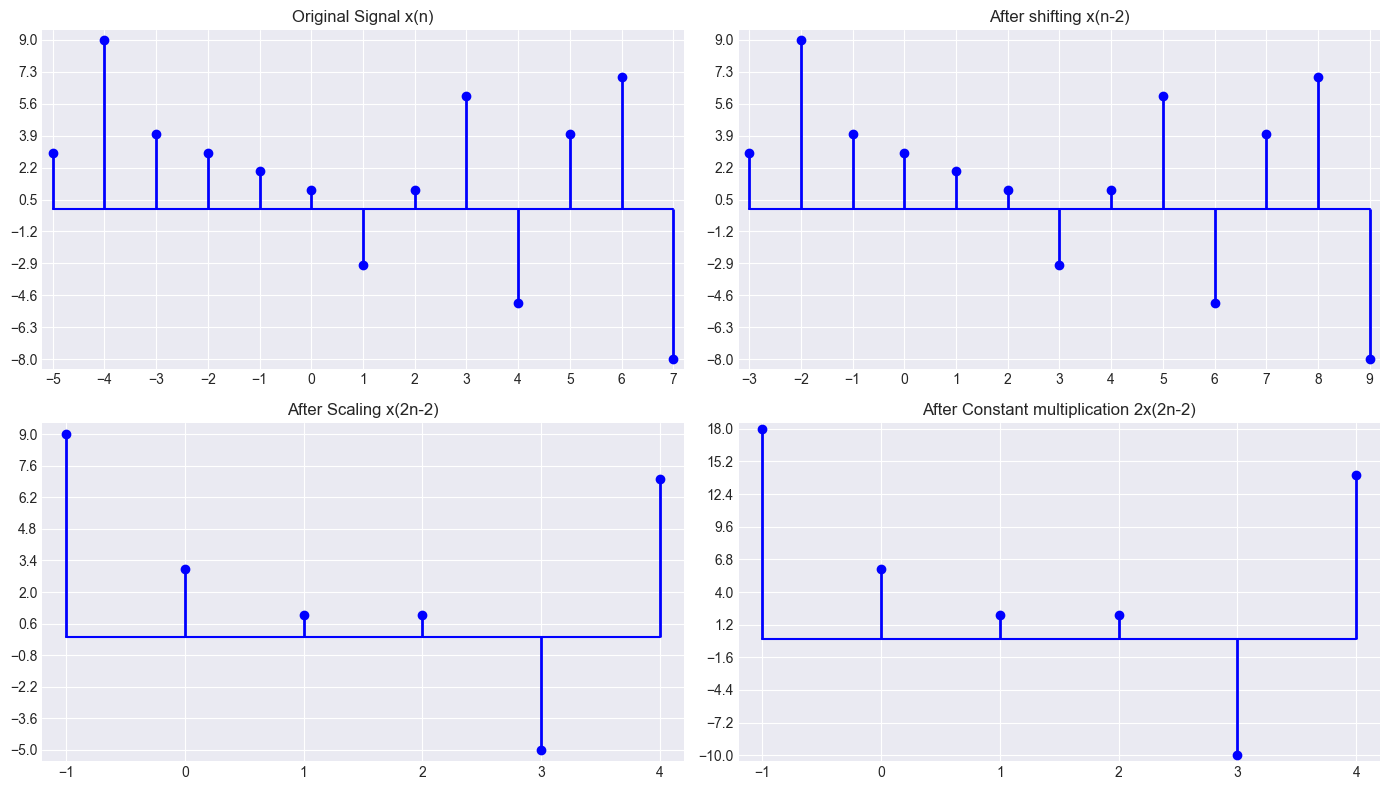

In [10]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
x.plot(title='Original Signal x(n)')
plt.subplot(2,2,2)
xs = T.shift_signal(x)
xs.plot('After shifting x(n-2)')
plt.subplot(2,2,3)
xs = T.scale_signal(xs)
xs.plot('After Scaling x(2n-2)')
plt.subplot(224)
xs = T.constant_multiply(xs)
xs.plot('After Constant multiplication 2x(2n-2)')
plt.tight_layout()
plt.show()